## Library

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydicom
from tqdm import tqdm
from skimage.transform import resize
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

## Init GPU

In [2]:
# Initialize GPU Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")

print(device)

GPU: Tesla T4 is available.
cuda


In [3]:
%load_ext autoreload
%autoreload 2

## Config Info

In [4]:
# Constants
HEIGHT = 224
WIDTH = 224
CHANNELS = 3

TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 2
TEST_BATCH_SIZE = 2
TEST_SIZE = 0.15
VALID_SIZE = 0.15

MAX_SLICES = 60
SHAPE = (HEIGHT, WIDTH, CHANNELS)

NUM_EPOCHS = 2
LEARNING_RATE = 5e-4

In [5]:
print(os.listdir('/kaggle/input/'))

['training_1000_scan_subset.csv', 'rsna-mil-training']


In [6]:
# Kaggle and local switch
import os

KAGGLE = os.path.exists('/kaggle')
print("Running on Kaggle" if KAGGLE else "Running locally")

DATA_DIR = '/kaggle/input/' if KAGGLE else '../rsna-mil-training/'
DICOM_DIR = DATA_DIR + 'rsna-mil-training/'
CSV_PATH = DATA_DIR + 'training_1000_scan_subset.csv' if KAGGLE else './data_analyze/training_1000_scan_subset.csv'

dicom_dir = DICOM_DIR if KAGGLE else DATA_DIR
# Load patient scan labels
patient_scan_labels = pd.read_csv(CSV_PATH)

Running on Kaggle


## Data Preprocessing

In [7]:
def correct_dcm(dcm):
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000

def window_image(dcm, window_center, window_width):    
    if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
        correct_dcm(dcm)
    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    
    # Resize
    img = cv2.resize(img, SHAPE[:2], interpolation = cv2.INTER_LINEAR)
   
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)
    return img

def bsb_window(dcm):
    brain_img = window_image(dcm, 40, 80)
    subdural_img = window_image(dcm, 80, 200)
    soft_img = window_image(dcm, 40, 380)
    
    brain_img = (brain_img - 0) / 80
    subdural_img = (subdural_img - (-20)) / 200
    soft_img = (soft_img - (-150)) / 380
    
    bsb_img = np.stack([brain_img, subdural_img, soft_img], axis=-1)
    return bsb_img.astype(np.float16)

In [8]:
def preprocess_slice(slice, target_size=(HEIGHT, WIDTH)):
    # Check if type of slice is dicom or an empty numpy array
    if (type(slice) == np.ndarray):
        slice = resize(slice, target_size, anti_aliasing=True)
        multichannel_slice = np.stack([slice, slice, slice], axis=-1)
        return multichannel_slice.astype(np.float16)
    else:
        slice = bsb_window(slice)
        return slice.astype(np.float16)

In [9]:
def read_dicom_folder(folder_path):
    slices = []
    for filename in sorted(os.listdir(folder_path))[:MAX_SLICES]:  # Limit to MAX_SLICES
        if filename.endswith(".dcm"):
            file_path = os.path.join(folder_path, filename)
            ds = pydicom.dcmread(file_path)
            slices.append(ds)
            
    # Sort slices by images position (z-coordinate) in ascending order
    slices = sorted(slices, key=lambda x: float(x.ImagePositionPatient[2]))
    
    # Pad with black images if necessary
    while len(slices) < MAX_SLICES:
        slices.append(np.zeros_like(slices[0].pixel_array))
    
    return slices[:MAX_SLICES]  # Ensure we return exactly MAX_SLICES

## Split Dataset

In [10]:
def split_dataset(patient_scan_labels, test_size=TEST_SIZE, val_size=VALID_SIZE, random_state=42):
    # If any of the hemorrhage indicators is 1, the label is 1, otherwise 0
    patient_scan_labels['label'] = patient_scan_labels[['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']].any(axis=1).astype(int)

    # Extract the labels from the DataFrame
    labels = patient_scan_labels['label']

    # First, split off the test set
    train_val_labels, test_labels = train_test_split(
        patient_scan_labels, 
        test_size=test_size, 
        stratify=labels, 
        random_state=random_state
    )

    # Calculate the validation size relative to the train_val set
    val_size_adjusted = val_size / (1 - test_size)

    # Split the train_val set into train and validation sets
    train_labels, val_labels = train_test_split(
        train_val_labels, 
        test_size=val_size_adjusted, 
        stratify=train_val_labels['label'], 
        random_state=random_state
    )

    return train_labels, val_labels, test_labels

In [11]:
def process_patient_data(dicom_dir, row, num_instances=12, depth=5):
    patient_id = row['patient_id'].replace('ID_', '')
    study_instance_uid = row['study_instance_uid'].replace('ID_', '')
    
    folder_name = f"{patient_id}_{study_instance_uid}"
    folder_path = os.path.join(dicom_dir, folder_name)
    
    if os.path.exists(folder_path):
        slices = read_dicom_folder(folder_path)
        
        # Ensure we have enough slices to create the specified instances
        if len(slices) < depth * num_instances:
            print(f"Not enough slices for patient {patient_id}: found {len(slices)}, needed {depth * num_instances}")
            return None, None
        
        preprocessed_slices = [preprocess_slice(slice) for slice in slices]
        
        # Stack preprocessed slices into an array
        preprocessed_slices = np.stack(preprocessed_slices, axis=0)  # (num_slices, height, width, channels)

        # Calculate how many complete instances we can form
        total_slices = preprocessed_slices.shape[0]
        
        # Reshape to (num_instances, depth, height, width, channels)
        reshaped_slices = preprocessed_slices[:num_instances * depth].reshape(num_instances, depth, *preprocessed_slices.shape[1:])  # (num_instances, depth, height, width, channels)
        
        # Labeling remains consistent  
        label = 1 if row[['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']].any() else 0
        
        return reshaped_slices, label
    else:
        print(f"Folder not found: {folder_path}")
        return None, None

In [12]:
class TrainDatasetGenerator(Dataset):
    """
    A custom dataset class for training data.
    """
    def __init__(self, data_dir, patient_scan_labels):
        self.data_dir = data_dir
        self.patient_scan_labels = patient_scan_labels

    def __len__(self):
        return len(self.patient_scan_labels)

    def __getitem__(self, idx):
        row = self.patient_scan_labels.iloc[idx]
        preprocessed_slices, label = process_patient_data(self.data_dir, row)
        
        if preprocessed_slices is not None:
            # Convert the list of numpy arrays to a single numpy array
            preprocessed_slices = np.array(preprocessed_slices)  # Convert to numpy array
            return torch.tensor(preprocessed_slices, dtype=torch.float32), torch.tensor(label, dtype=torch.long)
        else:
            return None, None  # Handle the case where the folder is not found

class TestDatasetGenerator(Dataset):
    """
    A custom dataset class for testing data.
    """
    def __init__(self, data_dir, patient_scan_labels):
        self.data_dir = data_dir
        self.patient_scan_labels = patient_scan_labels

    def __len__(self):
        return len(self.patient_scan_labels)

    def __getitem__(self, idx):
        row = self.patient_scan_labels.iloc[idx]
        preprocessed_slices, label = process_patient_data(self.data_dir, row)
        
        if preprocessed_slices is not None:
            # Convert the list of numpy arrays to a single numpy array
            preprocessed_slices = np.array(preprocessed_slices)  # Convert to numpy array
            return torch.tensor(preprocessed_slices, dtype=torch.float32), torch.tensor(label, dtype=torch.long)
        else:
            return None, None  # Handle the case where the folder is not found

In [13]:
def get_train_loader(dicom_dir, patient_scan_labels, batch_size=TRAIN_BATCH_SIZE, shuffle=True):
    train_dataset = TrainDatasetGenerator(dicom_dir, patient_scan_labels)
    return DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=4, pin_memory=True)

def get_test_loader(dicom_dir, patient_scan_labels, batch_size=TEST_BATCH_SIZE):
    test_dataset = TestDatasetGenerator(dicom_dir, patient_scan_labels)
    return DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

## CNN Feature Extractor

In [14]:
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.fc1 = nn.Linear(in_channels, in_channels // reduction, bias=False).to(device)
        self.fc2 = nn.Linear(in_channels // reduction, in_channels, bias=False).to(device)

    def forward(self, x):
        batch_size, channels, _, _, _ = x.size()
    
        avg_pool = F.adaptive_avg_pool3d(x, 1).view(batch_size, channels)
        max_pool = F.adaptive_max_pool3d(x, 1).view(batch_size, channels)

        avg_out = self.fc2(F.relu(self.fc1(avg_pool)))
        max_out = self.fc2(F.relu(self.fc1(max_pool)))

        out = torch.sigmoid(avg_out + max_out).view(batch_size, channels, 1, 1, 1)
        return out * x

In [15]:
class ResidualBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dropout_rate = 0.25):
        super(ResidualBlock3D, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm3d(out_channels)
        self.dropout = nn.Dropout3d(dropout_rate)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm3d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        
        # Apply channel attention methods
#         out = ChannelAttention(out.size(1))(out)
        
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [16]:
class ResNet3D_MIL(nn.Module):
    def __init__(self, block, num_blocks, num_classes=1):
        super(ResNet3D_MIL, self).__init__()
        self.in_channels = 16

        self.conv1 = nn.Conv3d(3, 16, kernel_size=7, stride=(1, 2, 2), padding=3, bias=False)
        self.bn1 = nn.BatchNorm3d(16)
        self.maxpool = nn.MaxPool3d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1, dropout_rate=0.2)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2, dropout_rate=0.2)
        self.layer3 = self._make_layer(block, 32, num_blocks[2], stride=2, dropout_rate=0.3)
        self.layer4 = self._make_layer(block, 32, num_blocks[3], stride=2, dropout_rate=0.3)
        self.layer5 = self._make_layer(block, 32, num_blocks[4], stride=2, dropout_rate=0.3)

        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        
        self.fc = nn.Linear(32, num_classes)
#         self.fc = nn.Linear(32 * num_blocks[-1], num_classes)  # Adjust based on number of blocks
        self.relu = nn.ReLU(inplace=True)

    def _make_layer(self, block, out_channels, num_blocks, stride, dropout_rate = 0.25):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride, dropout_rate))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        # x shape: (batch_size, num_instances, channels, depth, height, width)
        # print(x.size()) # 4, 12, 5, 224, 224, 3
        batch_size, num_instances, d, h, w, c = x.size()
        x = x.view(batch_size * num_instances, c, d, h, w)

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.maxpool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)

        out = self.avgpool(out)
        # print(f'out shape after avgpool: {out.size()}')
        
        # Reshape and aggregate features across instances
        out = out.view(batch_size, num_instances, -1)  # Reshape to (batch_size, num_instances, feature_dim)
        # print(f'X shape after aggregate features: {out.size()}')
        
        # Aggregate features (e.g., max pooling across instances)
        out = torch.max(out, dim=1)[0]  # Take max across instances
        # print(f'out shape after take max across instances: {out.size()}')
        
        # Final classification layer
        # out = torch.flatten(out)  
        
        # print(f"x classification layer shape: {out.size()}")
        
        return self.fc(out)

def ResNet3D18_MIL():
    return ResNet3D_MIL(ResidualBlock3D, [1, 1, 1, 1, 1])

In [17]:
def train_model(model, train_loader, val_loader, num_epochs=NUM_EPOCHS, learning_rate=LEARNING_RATE, device='cuda'):
    model = model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, steps_per_epoch=len(train_loader), epochs=num_epochs)
    
    best_val_accuracy = 0.0
    best_model = None

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_predictions = []
        train_labels = []

        for batch_data, batch_labels in train_loader:
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.float().to(device)

            optimizer.zero_grad()
            outputs = model(batch_data).squeeze()
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            train_loss += loss.item()
            train_predictions.extend((outputs > 0).cpu().numpy())
            train_labels.extend(batch_labels.cpu().numpy())

        train_accuracy = accuracy_score(train_labels, train_predictions)
        train_precision = precision_score(train_labels, train_predictions)
        train_recall = recall_score(train_labels, train_predictions)
        train_f1 = f1_score(train_labels, train_predictions)

        # Validation
        model.eval()
        val_loss = 0.0
        val_predictions = []
        val_labels = []

        with torch.no_grad():
            for batch_data, batch_labels in val_loader:
                batch_data = batch_data.to(device)
                batch_labels = batch_labels.float().to(device)

                outputs = model(batch_data).squeeze()
                loss = criterion(outputs, batch_labels)

                val_loss += loss.item()
                val_predictions.extend((outputs > 0).cpu().numpy())
                val_labels.extend(batch_labels.cpu().numpy())

        val_accuracy = accuracy_score(val_labels, val_predictions)
        val_precision = precision_score(val_labels, val_predictions)
        val_recall = recall_score(val_labels, val_predictions)
        val_f1 = f1_score(val_labels, val_predictions)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model = model.state_dict()

    # Load best model
    model.load_state_dict(best_model)
    return model

In [18]:
def test_model(model, test_loader, device='cuda'):
    model = model.to(device)
    model.eval()
    test_predictions = []
    test_labels = []

    with torch.no_grad():
        for batch_data, batch_labels in test_loader:
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.float().to(device)

            outputs = model(batch_data).squeeze()
            test_predictions.extend((outputs > 0).cpu().numpy())
            test_labels.extend(batch_labels.cpu().numpy())

    test_accuracy = accuracy_score(test_labels, test_predictions)
    test_precision = precision_score(test_labels, test_predictions)
    test_recall = recall_score(test_labels, test_predictions)
    test_f1 = f1_score(test_labels, test_predictions)

    print(f"Test Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}")

    return test_accuracy, test_precision, test_recall, test_f1

In [19]:
def plot_roc_curve(model, data_loader, device):
    model.eval()
    all_labels = []
    all_scores = []
    with torch.no_grad():
        for batch_data, batch_labels in data_loader:
            batch_data = batch_data.to(device)
            outputs = model(batch_data).squeeze()
            all_scores.extend(outputs.cpu().numpy())
            all_labels.extend(batch_labels.numpy())
    
    fpr, tpr, _ = roc_curve(all_labels, all_scores)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [20]:
def plot_confusion_matrix(model, test_loader, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for batch_data, batch_labels in test_loader:
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.to(device)

            outputs = model(batch_data).squeeze()
            predictions = (outputs > 0).cpu().numpy()

            y_true.extend(batch_labels.cpu().numpy())
            y_pred.extend(predictions)

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title('Confusion Matrix')
    plt.show()

Epoch 1/2
Train Loss: 122.5563, Accuracy: 0.5357, Precision: 0.5268, Recall: 0.7029, F1: 0.6022
Val Loss: 56.0086, Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/2
Train Loss: 119.1040, Accuracy: 0.5671, Precision: 0.5723, Recall: 0.5314, F1: 0.5511
Val Loss: 50.0507, Accuracy: 0.6133, Precision: 0.5691, Recall: 0.9333, F1: 0.7071


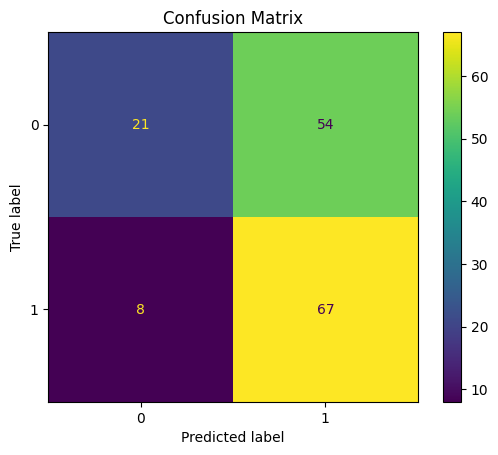

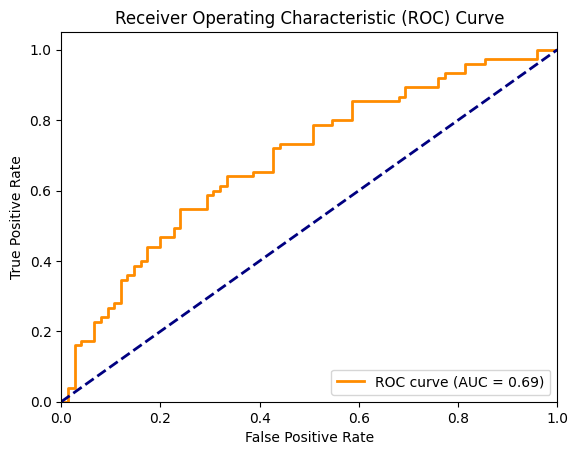

In [21]:
if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model = ResNet3D18_MIL()
    
    train_labels, val_labels, test_labels = split_dataset(patient_scan_labels, test_size=TEST_SIZE)
    
    train_loader = get_train_loader(dicom_dir, train_labels, batch_size=TRAIN_BATCH_SIZE)
    val_loader = get_train_loader(dicom_dir, val_labels, batch_size=VALID_BATCH_SIZE)
    test_loader = get_test_loader(dicom_dir, test_labels, batch_size=TEST_BATCH_SIZE)
    
    trained_model = train_model(model, train_loader, val_loader, num_epochs=NUM_EPOCHS, learning_rate=LEARNING_RATE)
    
    # Plot the Confusion Matrix
    plot_confusion_matrix(trained_model, test_loader, device)
    
    # Save the model
    torch.save(trained_model.state_dict(), 'trained_model.pth')
    
    plot_roc_curve(trained_model, test_loader, device)

In [22]:
# Load the model and test it on test loader and print the results of classification to a csv 
model = ResNet3D18_MIL()
# Load the trained model
model.load_state_dict(torch.load('trained_model.pth', weights_only=True))
model.eval()

test_model(model, test_loader)

# Save the results to a csv file
results = []
with torch.no_grad():
    for batch_data, batch_labels in test_loader:
        batch_data = batch_data.to(device)
        batch_labels = batch_labels.float().to(device)

        outputs = model(batch_data).squeeze()
        predictions = (outputs > 0).cpu().numpy()

        for i in range(len(predictions)):
            results.append({
                'prediction': predictions[i],
                'label': batch_labels[i].cpu().numpy()
            })

results_df = pd.DataFrame(results)
results_df.to_csv('results.csv', index=False)
results_df.head()

Test Accuracy: 0.5867, Precision: 0.5537, Recall: 0.8933, F1: 0.6837


,prediction,label
0,False,1.0
1,True,1.0
2,True,0.0
3,False,1.0
4,True,1.0


torch.Size([12, 5, 224, 224, 3])


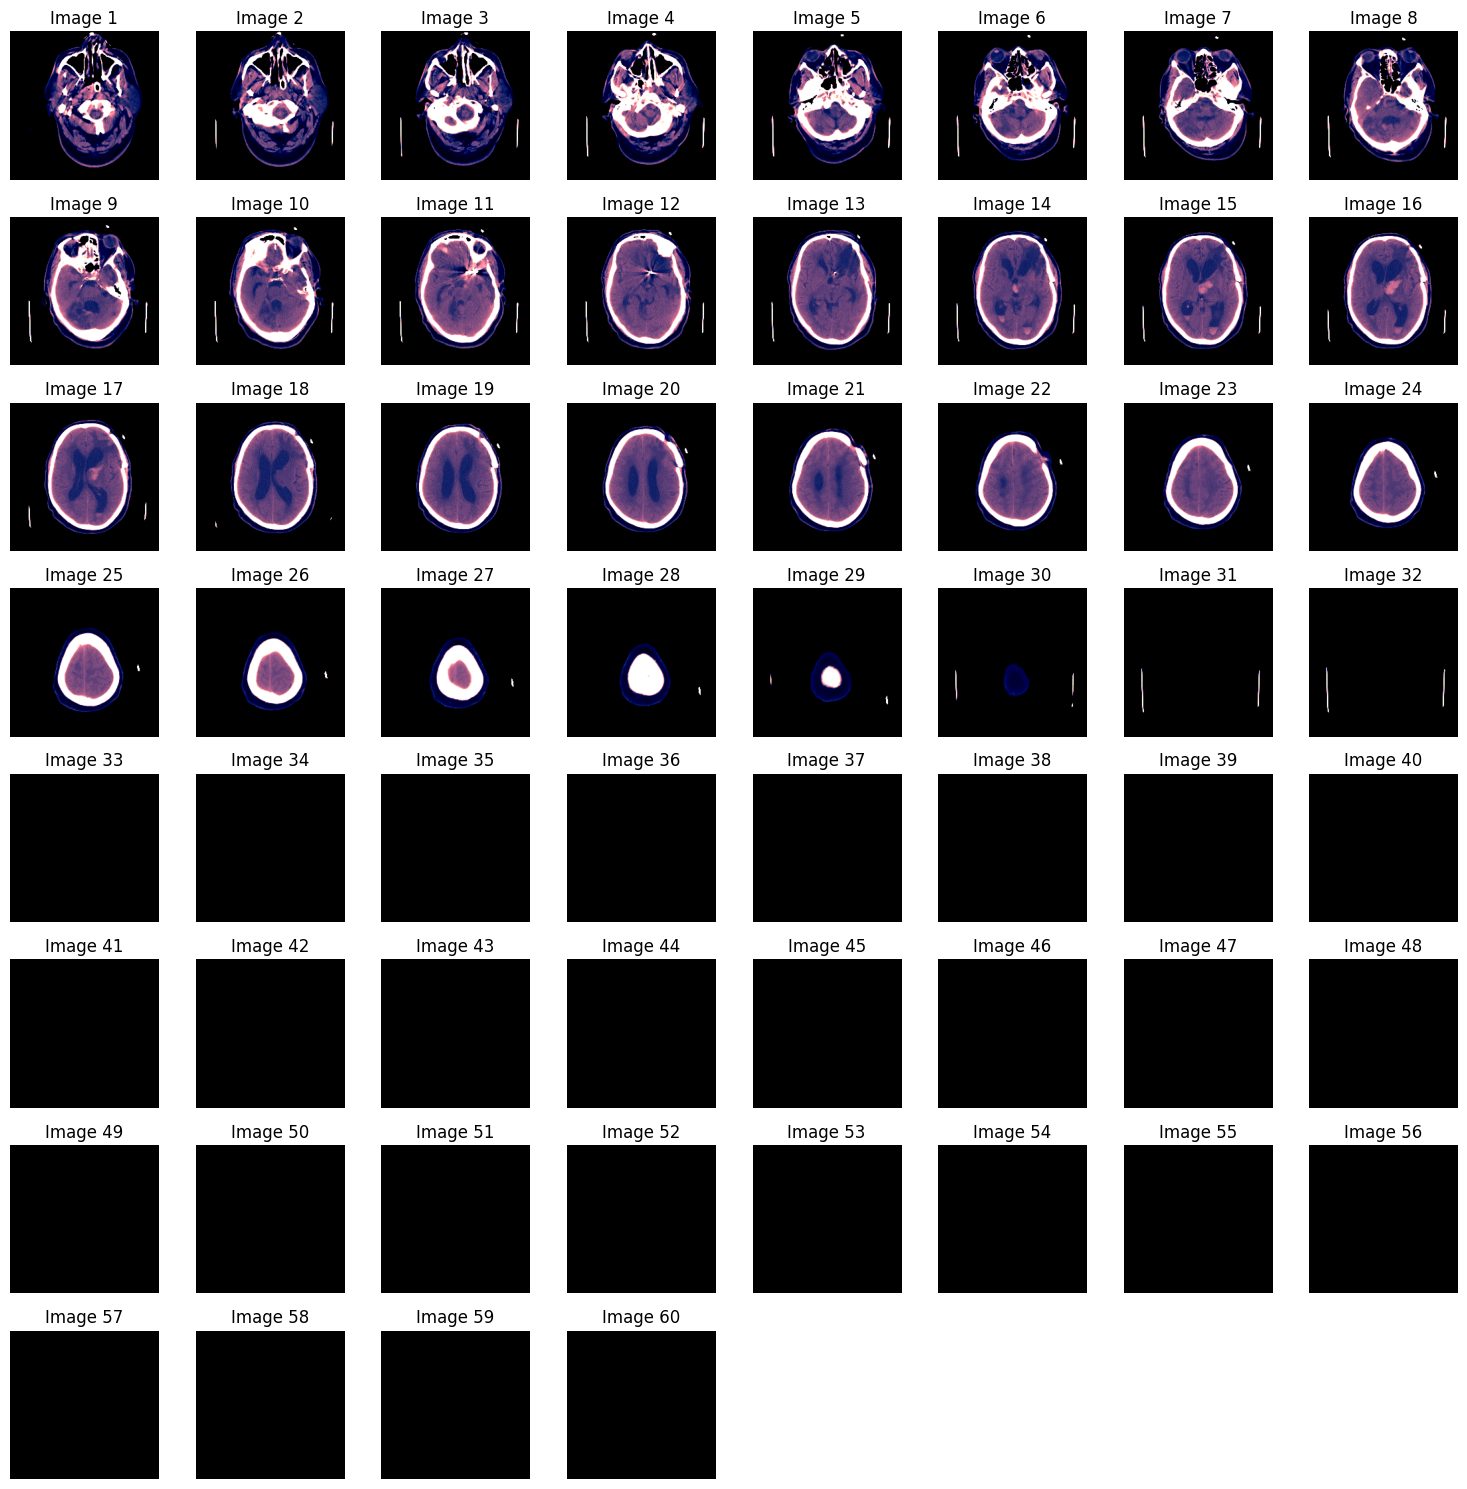

In [23]:
def plot_first_item(dataloader):
    first_item = next(iter(dataloader))
    
    images, labels = first_item[0]

    print(images.shape)
    batch_size, num_images_per_batch, height, width, channels = images.shape
    images = images.view(batch_size * num_images_per_batch, height, width, channels)
    
    num_images = images.size(0) 
    images = images.numpy()
    
    plt.figure(figsize=(15, 15))
    
    for i in range(num_images):
        plt.subplot(8, 8, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f'Image {i + 1}')
        plt.axis('off')
    
    plt.tight_layout() 
    plt.show()

# Call the function with the test_loader
plot_first_item(test_loader)